In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [21]:
# Librerías estándar
import math

# Librerías de terceros: manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para Matplotlib
plt.rcParams['figure.figsize'] = [25, 8]

# Librerías de terceros: machine learning y métricas
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Librerías de terceros: series de tiempo y clustering
from tslearn.clustering import silhouette_score, TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Importaciones específicas del proyecto
from lightweight_clustered_energy_forecasts.utils.paths import data_dir


## Funciones auxiliares

In [22]:
def nan_counter(list_of_dataframes):
    nan_polluted_series_counter = 0
    for dataframe in list_of_dataframes:
        if dataframe.isna().any().any():  # Verifica si hay NaN en cualquier columna
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)


## Procesing data

In [23]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [24]:
building_11a=building_11a.resample("h").sum()

In [25]:
#realizamos una lista de arrays cada array correspondiendo a 1 dia de datos con frecuencia de muestreo por 15 minutos
# Agrupar por día
df=building_11a.copy()
# Agrupar por día y guardar los DataFrames en una lista
list_of_dataframes = [group for _, group in df.groupby(df.index.date)]

# Imprimir el resultado
for i, daily_df in enumerate(list_of_dataframes):
    print(f"Día {i+1}:")
    print(daily_df)
    print("-" * 50)


Día 1:
                             kwh
timestamp                       
2023-01-01 00:00:00+00:00  54.90
2023-01-01 01:00:00+00:00  53.81
2023-01-01 02:00:00+00:00  52.92
2023-01-01 03:00:00+00:00  55.99
2023-01-01 04:00:00+00:00  57.55
2023-01-01 05:00:00+00:00  53.89
2023-01-01 06:00:00+00:00  52.87
2023-01-01 07:00:00+00:00  46.73
2023-01-01 08:00:00+00:00  51.08
2023-01-01 09:00:00+00:00  55.15
2023-01-01 10:00:00+00:00  51.41
2023-01-01 11:00:00+00:00  57.62
2023-01-01 12:00:00+00:00  56.59
2023-01-01 13:00:00+00:00  59.29
2023-01-01 14:00:00+00:00  61.22
2023-01-01 15:00:00+00:00  60.16
2023-01-01 16:00:00+00:00  57.73
2023-01-01 17:00:00+00:00  59.19
2023-01-01 18:00:00+00:00  61.27
2023-01-01 19:00:00+00:00  65.10
2023-01-01 20:00:00+00:00  57.67
2023-01-01 21:00:00+00:00  58.05
2023-01-01 22:00:00+00:00  59.79
2023-01-01 23:00:00+00:00  60.30
--------------------------------------------------
Día 2:
                             kwh
timestamp                       
2023-01-02 

In [26]:
nan_counter(list_of_dataframes)

0


In [27]:
len(list_of_dataframes)

365

<Axes: xlabel='timestamp'>

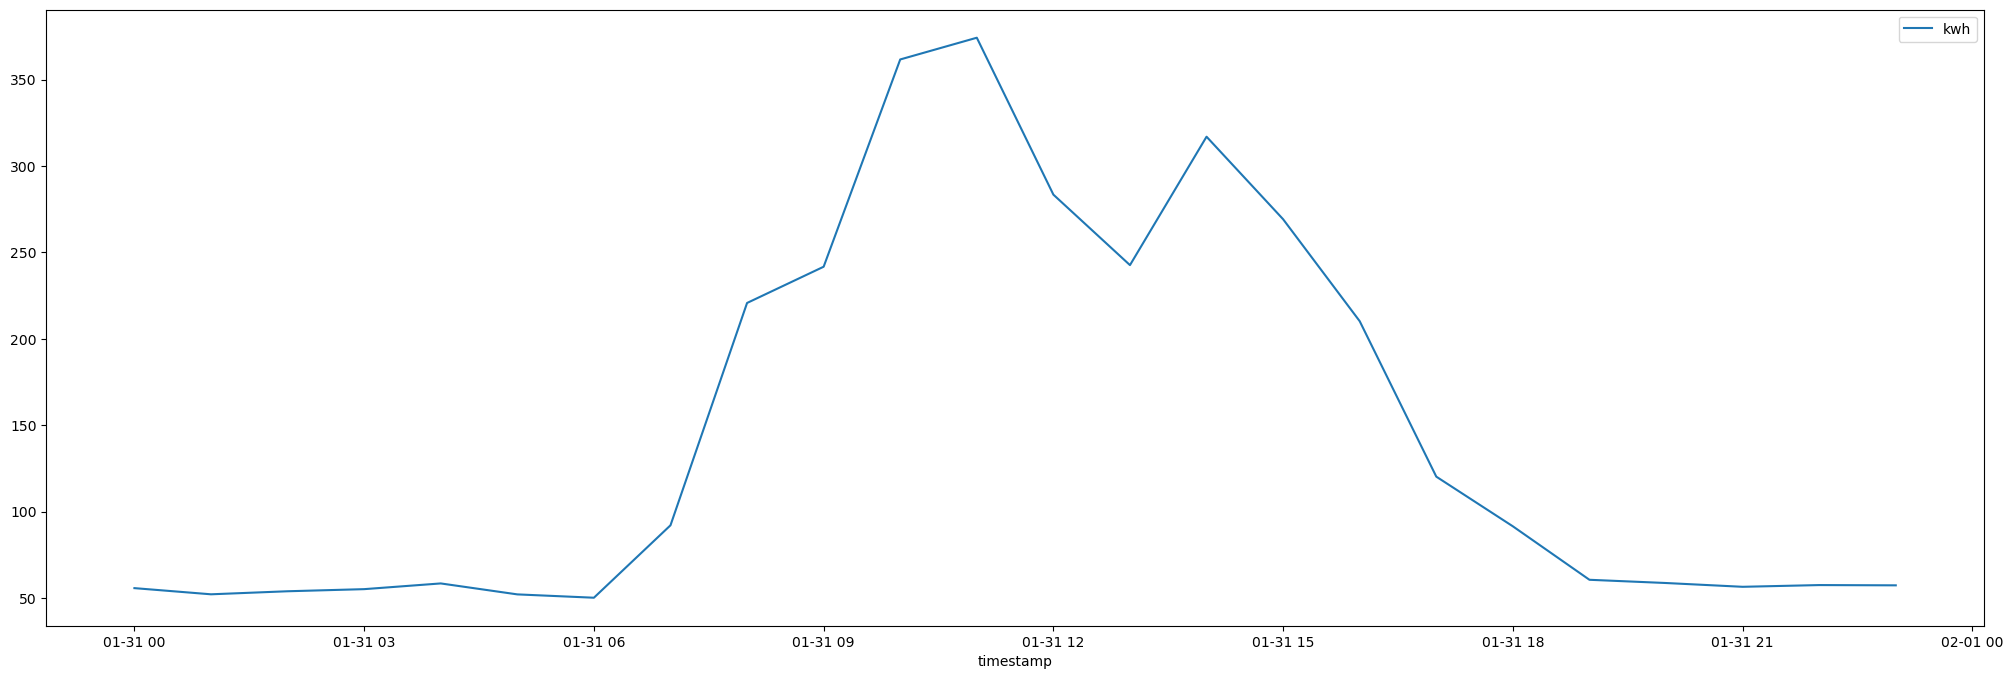

In [28]:
sns.lineplot(list_of_dataframes[30])

## clustering

Después de gestionar los valores faltantes, el otro problema es la escala de la serie. Sin la normalización de los datos, las series que se parecen entre sí se verán muy diferentes entre sí y afectarán la precisión del proceso de agrupamiento. Podemos ver el efecto de la normalización en las siguientes imágenes.

In [29]:
normalized_list_of_dataframes = []

for daily_df in list_of_dataframes:
    scaler = MinMaxScaler()
    # Normalizar cada día por separado
    normalized_daily_df = scaler.fit_transform(daily_df.values.reshape(-1, 1))  # Reshape para ajustarse a la entrada del scaler
    normalized_list_of_dataframes.append(normalized_daily_df.flatten())  # Volver a la forma 1D


El resultado del proceso de normalización parece bueno.

In [30]:
print("max: "+str(max(normalized_list_of_dataframes[0]))+"\tmin: "+str(min(normalized_list_of_dataframes[0])))
print(normalized_list_of_dataframes[0][:5])

max: 1.0	min: 0.0
[0.44474687 0.385411   0.33696244 0.50408274 0.58900381]


## kmeans

In [31]:
# Definir el rango de k para probar
K = range(2, 8)
Sum_of_squared_distances = []
Silhouette_Scores = []

# Probar con diferentes valores de k
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",  # Usamos DTW como métrica de distancia
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    # Ajustar el modelo a los datos
    km = km.fit(normalized_list_of_dataframes)
    
    # Almacenar la inercia para este valor de k
    Sum_of_squared_distances.append(km.inertia_)
    silhouette = silhouette_score(normalized_list_of_dataframes, km.labels_)
    Silhouette_Scores.append(silhouette)

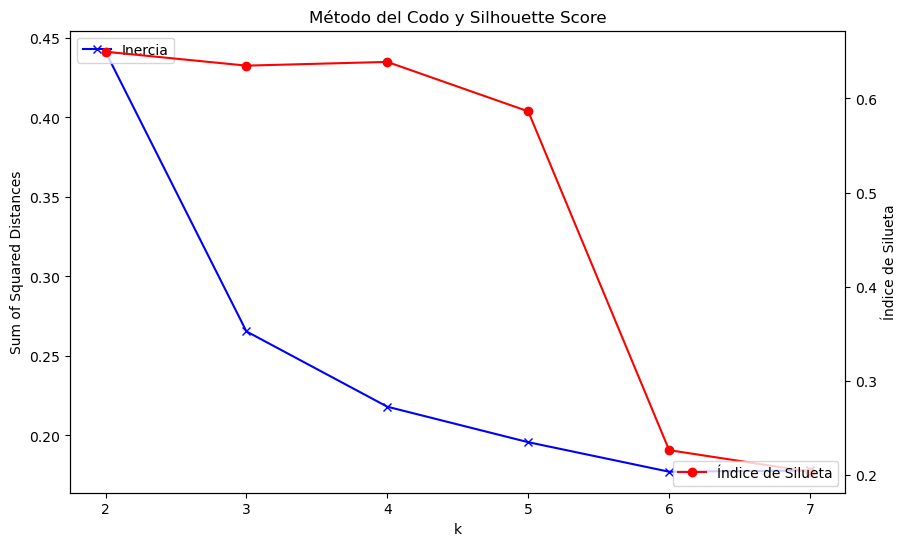

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico del codo (inercia)
ax1.plot(K, Sum_of_squared_distances, 'bx-', label="Inercia")
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of Squared Distances')
ax1.set_title('Método del Codo y Silhouette Score')

# Crear un segundo eje y para el índice de silueta
ax2 = ax1.twinx()
ax2.plot(K, Silhouette_Scores, 'ro-', label="Índice de Silueta")
ax2.set_ylabel('Índice de Silueta')

# Mostrar la leyenda
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

In [33]:
Sum_of_squared_distances

[np.float64(0.44130106822624143),
 np.float64(0.2654060092499969),
 np.float64(0.21803211406482984),
 np.float64(0.19572773501533122),
 np.float64(0.17714936074504653),
 np.float64(0.17794310812958056)]

## Training  kmeans 

usando distancia Euclidiana

In [34]:
# Aplicar el clustering con el número óptimo de clusters
optimal_k = 4
km = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", verbose=False)

# Ajustar el modelo y predecir las etiquetas de los clusters
labels = km.fit_predict(normalized_list_of_dataframes)

# Mostrar las primeras etiquetas de los clusters
print("Etiquetas de los clusters para las primeras series:", labels[:5])


Etiquetas de los clusters para las primeras series: [3 3 0 0 0]


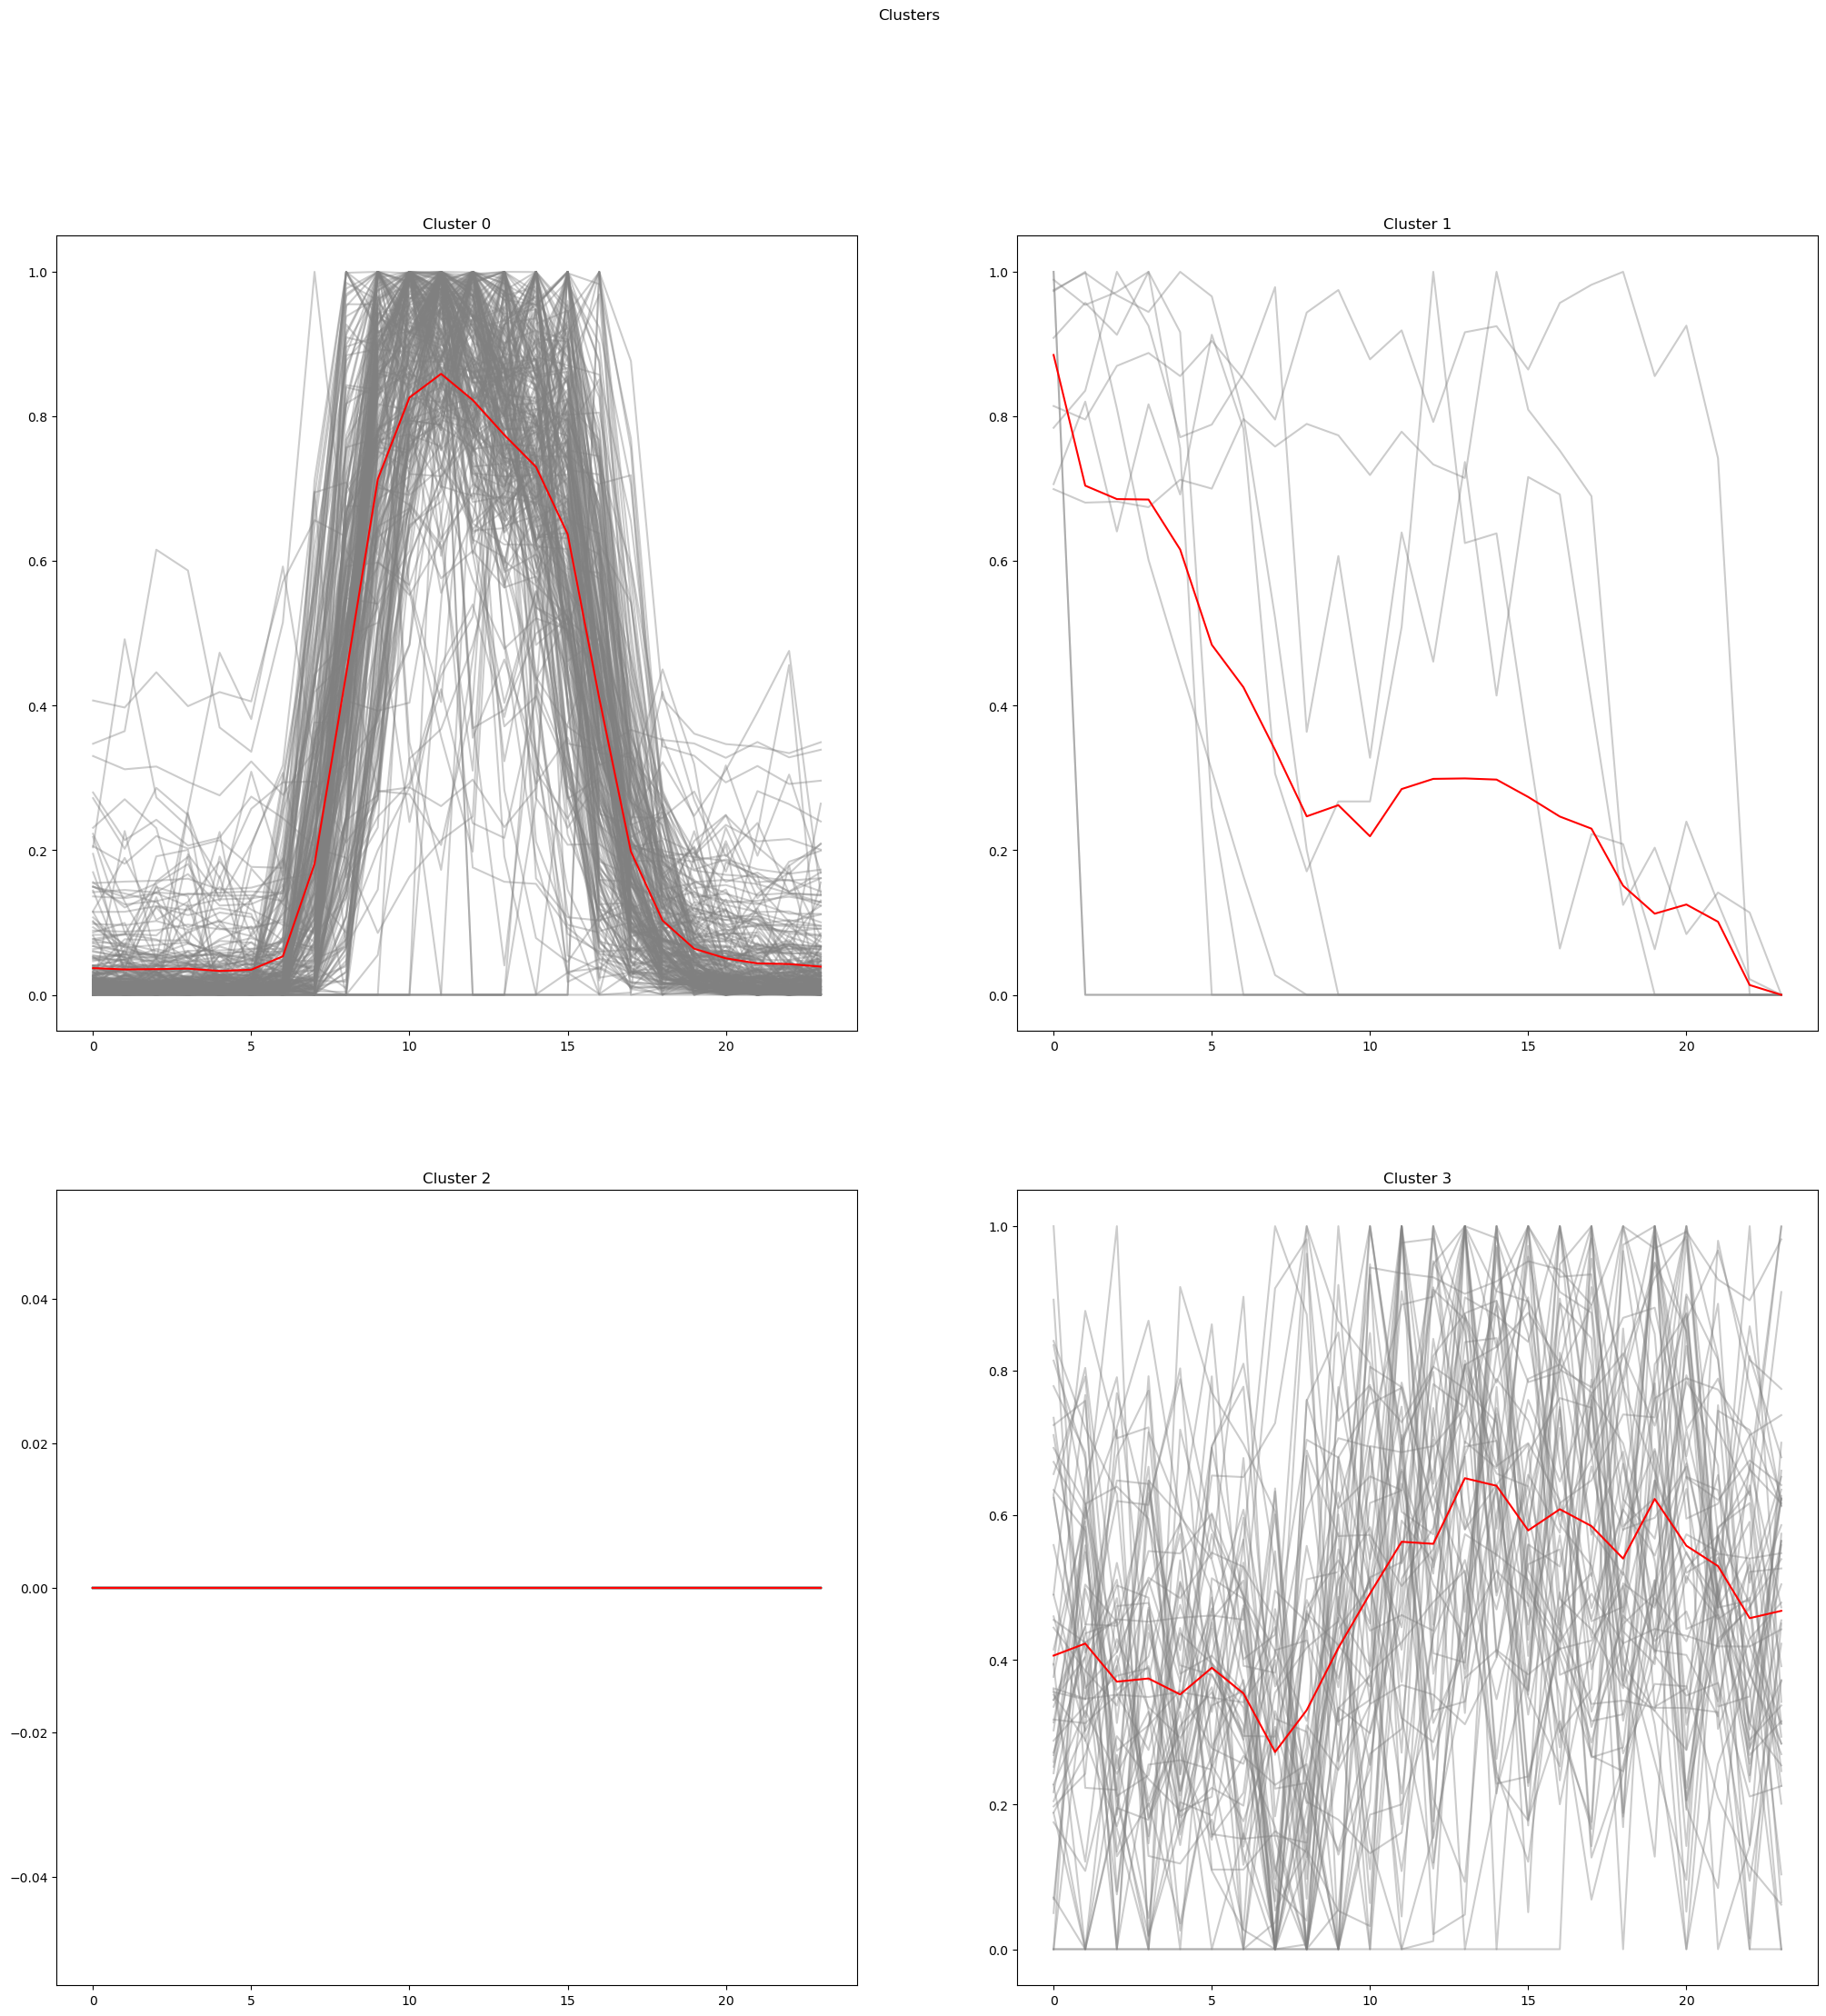

In [35]:
# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

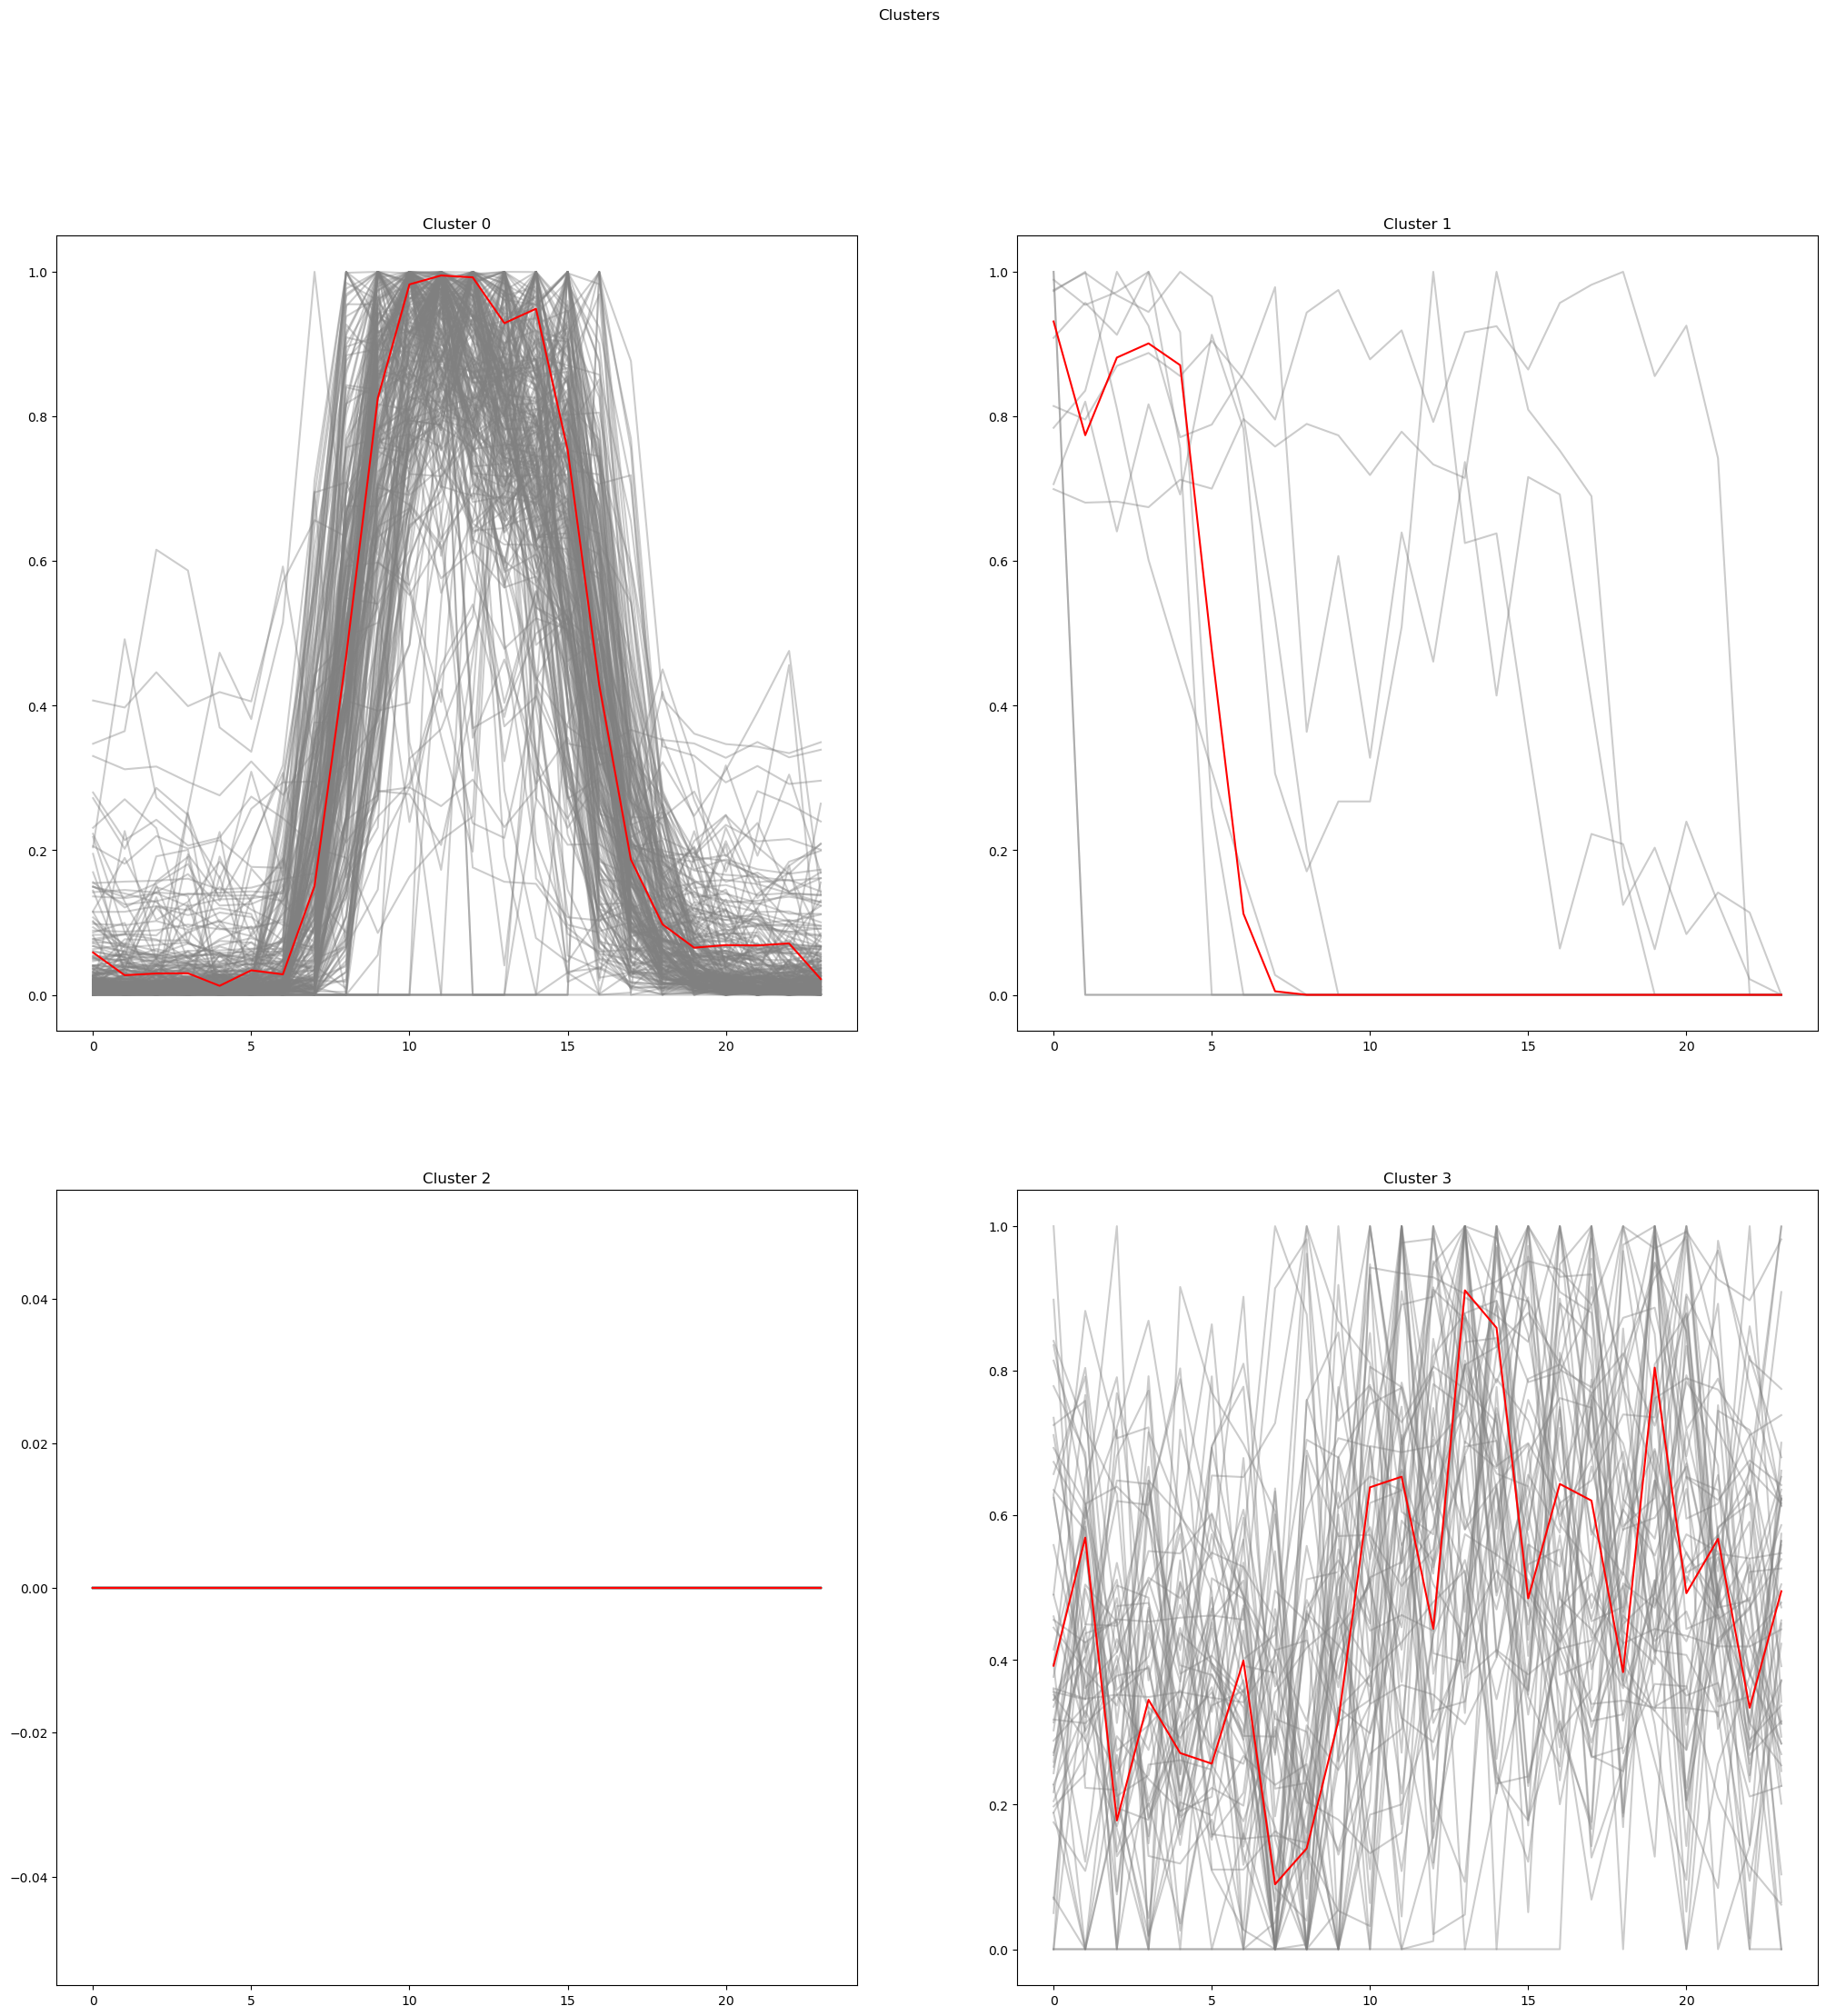

In [37]:
from tslearn.barycenters import dtw_barycenter_averaging

# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

Cantidad de series en cada cluster: [np.int64(249), np.int64(10), np.int64(49), np.int64(57)]


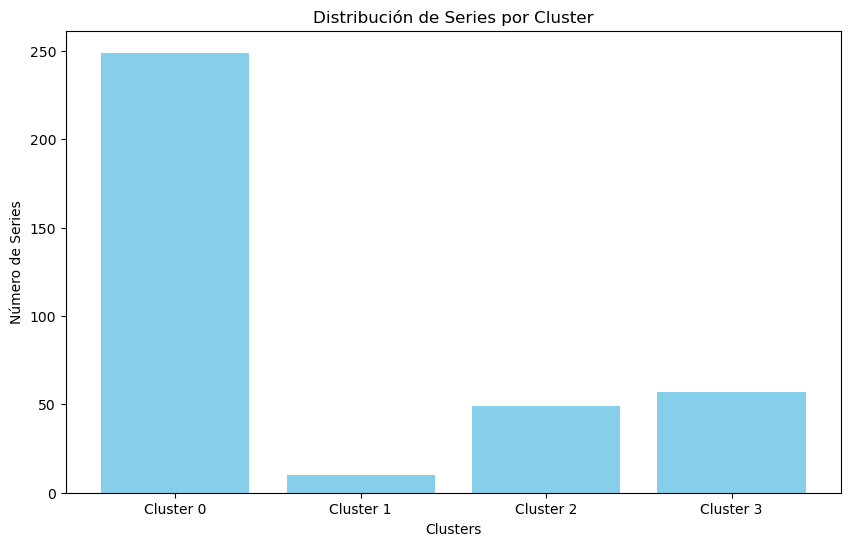

In [38]:
# Contar cuántas series pertenecen a cada cluster
cluster_counts = [np.sum(labels == i) for i in range(optimal_k)]

# Mostrar la cantidad de series en cada cluster
print("Cantidad de series en cada cluster:", cluster_counts)

# Etiquetas para los clusters
cluster_labels = [f"Cluster {i}" for i in range(optimal_k)]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(cluster_labels, cluster_counts, color='skyblue')
plt.title("Distribución de Series por Cluster")
plt.xlabel("Clusters")
plt.ylabel("Número de Series")
plt.show()


In [74]:
# Crear una lista vacía para almacenar las fechas y las etiquetas de los clusters
dates = []
cluster_labels = []

# Recorrer las series de tiempo, y asignar las fechas y las etiquetas correspondientes
for i, daily_df in enumerate(list_of_dataframes):
    current_dates = daily_df.index  # Obtener las fechas de este día
    dates.extend(current_dates)  # Añadir las fechas
    cluster_labels.extend([labels[i]] * len(current_dates))  # Añadir la etiqueta del cluster para cada fecha

# Crear un DataFrame con las fechas y las etiquetas de los clusters
df_clusters = pd.DataFrame({
    'Date': dates,
    'Cluster': cluster_labels
})

# Ver las primeras filas para verificar
df_clusters.head()


Date  Cluster
0 2023-01-01 00:00:00+00:00        3
1 2023-01-01 01:00:00+00:00        3
2 2023-01-01 02:00:00+00:00        3
3 2023-01-01 03:00:00+00:00        3
4 2023-01-01 04:00:00+00:00        3

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_23636\661334166.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)


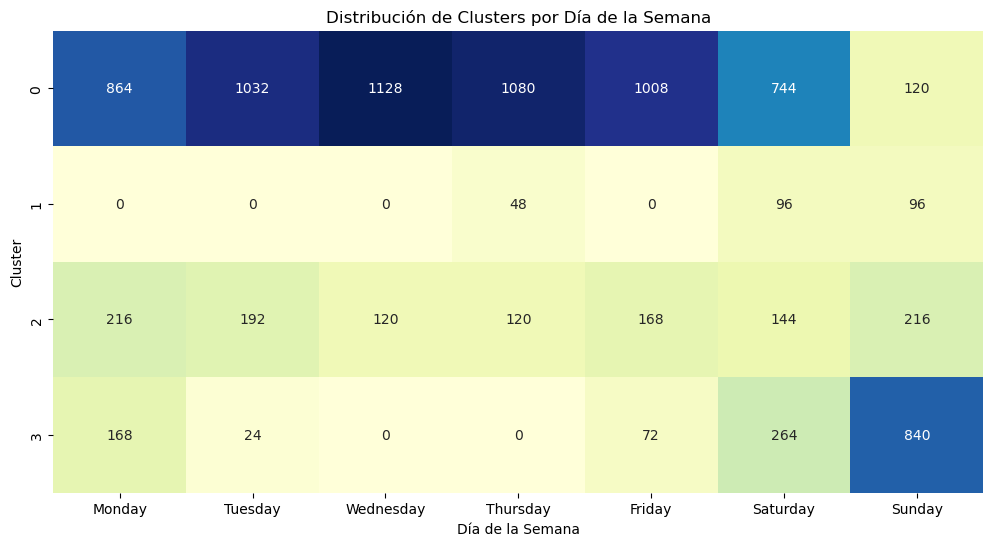

In [75]:
# Definir el orden correcto de los días de la semana
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)
df_clusters['Weekday'] = pd.to_datetime(df_clusters['Date']).dt.day_name()
# Convertir la columna 'Weekday' en una categoría ordenada
df_clusters['Weekday'] = df_clusters['Weekday'].astype(weekday_dtype)
df_clusters=df_clusters.sort_values(by="Weekday")
# Agrupar por cluster y día de la semana
weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)

import seaborn as sns

# Mostrar la distribución por día de la semana
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cluster')
plt.show()


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_23636\3457593411.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)


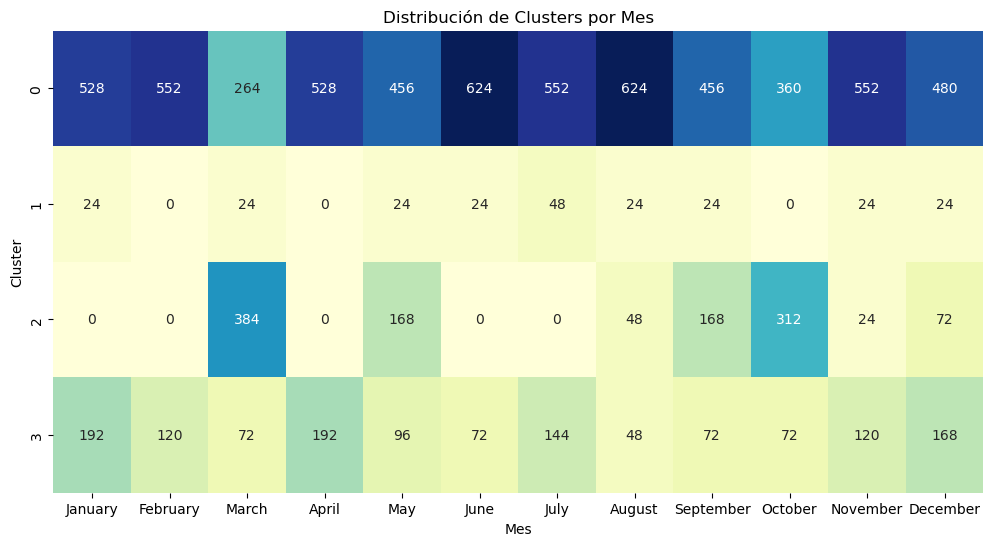

In [76]:
# Definir el orden correcto de los meses del año
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_dtype = pd.CategoricalDtype(categories=month_order, ordered=True)
df_clusters['Month'] = pd.to_datetime(df_clusters['Date']).dt.month_name()
# Convertir la columna 'Month' en una categoría ordenada
df_clusters['Month'] = df_clusters['Month'].astype(month_dtype)
df_clusters=df_clusters.sort_values(by="Month")

# Agrupar por cluster y mes
month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)

# Mostrar la distribución por mes
plt.figure(figsize=(12, 6))
sns.heatmap(month_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Mes')
plt.xlabel('Mes')
plt.ylabel('Cluster')
plt.show()


Obtaining the original data with the cluster label

In [81]:
df_clusters =df_clusters.sort_values(by="Date").rename(columns={"Date": "timestamp"})
data_clustered=building_11a.reset_index()

In [91]:
data_clustered=data_clustered.merge(df_clusters[["timestamp", "Cluster"]],on="timestamp",how="left")

In [92]:
data_clustered

timestamp    kwh  Cluster
0    2023-01-01 00:00:00+00:00  54.90        3
1    2023-01-01 01:00:00+00:00  53.81        3
2    2023-01-01 02:00:00+00:00  52.92        3
3    2023-01-01 03:00:00+00:00  55.99        3
4    2023-01-01 04:00:00+00:00  57.55        3
...                        ...    ...      ...
8755 2023-12-31 19:00:00+00:00  70.52        3
8756 2023-12-31 20:00:00+00:00  72.07        3
8757 2023-12-31 21:00:00+00:00  72.65        3
8758 2023-12-31 22:00:00+00:00  71.43        3
8759 2023-12-31 23:00:00+00:00  65.27        3

[8760 rows x 3 columns]

## Forecasting

In [102]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [103]:
# Crear características temporales
def create_features(df):
    """
    Create time series features based on the 'timestamp' column.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.isocalendar().week
    return df

In [104]:
# Agregar lags a las series de tiempo
def add_lags(df):
    df = df.copy()
    df['lag1'] = df['kwh'].shift(24)  # Lag de 1 día (24 horas)
    df['lag2'] = df['kwh'].shift(48)  # Lag de 2 días
    df['lag3'] = df['kwh'].shift(72)  # Lag de 3 días
    return df

In [105]:
# Calcular sMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = numerator / denominator
    return ratio.mean()

In [106]:
# Separar datos en entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

In [107]:
train

timestamp    kwh  Cluster
0    2023-01-01 00:00:00+00:00  54.90        3
1    2023-01-01 01:00:00+00:00  53.81        3
2    2023-01-01 02:00:00+00:00  52.92        3
3    2023-01-01 03:00:00+00:00  55.99        3
4    2023-01-01 04:00:00+00:00  57.55        3
...                        ...    ...      ...
8563 2023-12-23 19:00:00+00:00  68.53        3
8564 2023-12-23 20:00:00+00:00  64.13        3
8565 2023-12-23 21:00:00+00:00  66.19        3
8566 2023-12-23 22:00:00+00:00  63.71        3
8567 2023-12-23 23:00:00+00:00  66.08        3

[8568 rows x 3 columns]

In [108]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

In [109]:
# Entrenamiento del modelo
def entrenamiento_modelo(cluster, data, data_cluster):
    # Filtrar las series del cluster actual
    cluster_data = data[data['Cluster'] == cluster].dropna()
    
    # Separar las características (X) y el target (y)
    X_train = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
    y_train = cluster_data['kwh']
    
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    cluster_data['predictions'] = y_train_pred
    predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    return model, predict_df

In [110]:
# Inferencia
def inference_models(cluster, data, models):
    cluster_data = data[data['Cluster'] == cluster].dropna()
    model = models.get(f"{cluster}")
    if not cluster_data.empty:
        X_infer = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
        y_test_pred = model.predict(X_infer)
        cluster_data['predictions'] = y_test_pred
        predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    else:
        print(f"No hay datos en el testeo para el Cluster {cluster}")
        predict_df = pd.DataFrame()
    return predict_df


In [112]:
# Entrenamiento e inferencia por clusters
models = {}
train_results = pd.DataFrame()
test_results = pd.DataFrame()

for cluster in data_clustered['Cluster'].unique():
    print(f"\nEntrenando modelo para el Cluster {cluster}...")
    modelo, prediction_train = entrenamiento_modelo(cluster, train, data_clustered)
    models[f"{cluster}"] = modelo
    train_results = pd.concat([train_results, prediction_train], ignore_index=True)
    inference = inference_models(cluster, test, models)
    test_results = pd.concat([test_results, inference], ignore_index=True)

# Ordenar resultados
train_results = train_results.sort_values(by="timestamp")
test_results = test_results.sort_values(by="timestamp")



Entrenando modelo para el Cluster 3...

Entrenando modelo para el Cluster 0...

Entrenando modelo para el Cluster 1...
No hay datos en el testeo para el Cluster 1

Entrenando modelo para el Cluster 2...
No hay datos en el testeo para el Cluster 2


In [117]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 89.51607551281377
smape: 0.2721801374469582


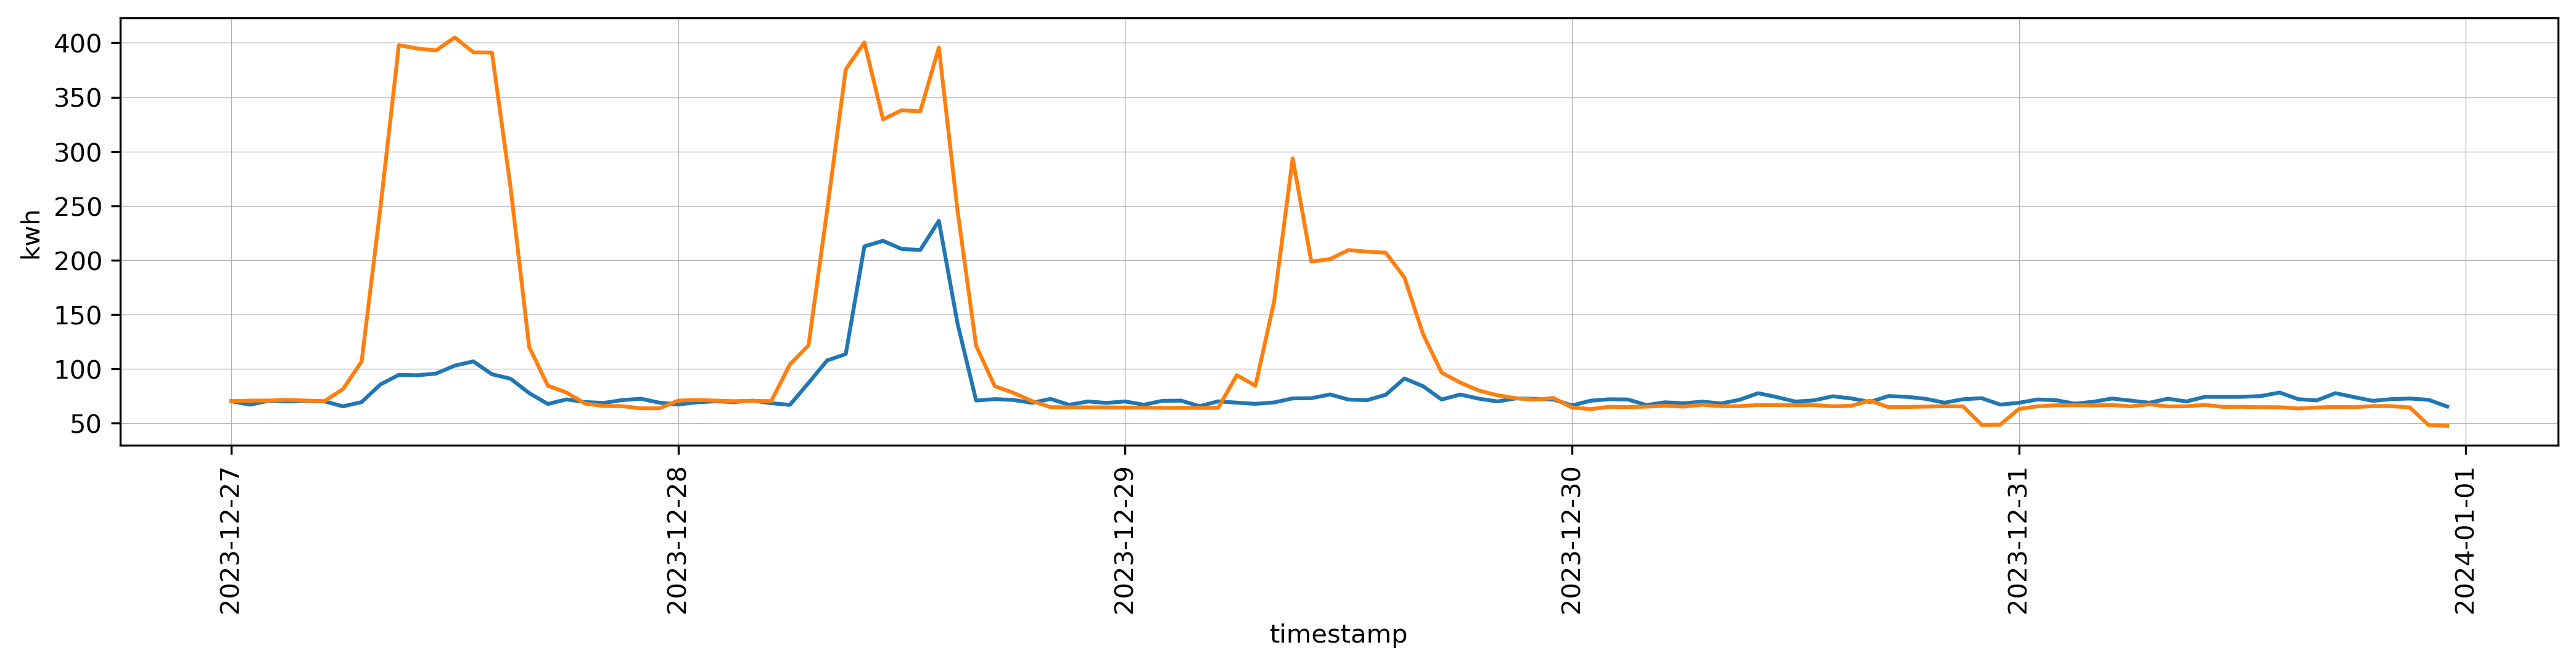

In [119]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Tunning models

In [132]:
models={}

## Tunning model cluster 0

In [150]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [151]:
# Filtrar datos por cluster
cluster = 0
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [152]:
cluster_data_train

timestamp    kwh  Cluster  hour  dayofweek  quarter  \
72   2023-01-04 00:00:00+00:00  79.78        0     0          2        1   
73   2023-01-04 01:00:00+00:00  54.80        0     1          2        1   
74   2023-01-04 02:00:00+00:00  65.23        0     2          2        1   
75   2023-01-04 03:00:00+00:00  66.51        0     3          2        1   
76   2023-01-04 04:00:00+00:00  57.10        0     4          2        1   
...                        ...    ...      ...   ...        ...      ...   
8539 2023-12-22 19:00:00+00:00  73.68        0    19          4        4   
8540 2023-12-22 20:00:00+00:00  67.04        0    20          4        4   
8541 2023-12-22 21:00:00+00:00  66.35        0    21          4        4   
8542 2023-12-22 22:00:00+00:00  63.87        0    22          4        4   
8543 2023-12-22 23:00:00+00:00  62.43        0    23          4        4   

      month  dayofyear  dayofmonth  weekofyear   lag1   lag2    lag3  
72        1          4           4           1  57.00  59.37   54.90  
73        1          4           4           1  51.58  58.62   53.81  
74        1          4           4           1  53.44  62.51   52.92  
75        1          4           4           1  54.54  52.88   55.99  
76        1          4           4           1  50.76  59.80   57.55  
...     ...        ...         ...         ...    ...    ...     ...  
8539     12        356          22          51  72.09  67.42  106.21  
8540     12        356          22          51  69.02  65.17   88.32  
8541     12        356          22          51  69.88  63.79   75.18  
8542     12        356          22          51  67.08  64.17   84.09  
8543     12        356          22          51  63.91  61.90   77.96  

[5856 rows x 13 columns]

In [153]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:160.01833	validation_1-mae:194.48493
[100]	validation_0-mae:66.05404	validation_1-mae:83.99007
[200]	validation_0-mae:45.49900	validation_1-mae:57.28475
[300]	validation_0-mae:41.65898	validation_1-mae:50.31378
[369]	validation_0-mae:40.62552	validation_1-mae:51.25491
[0]	validation_0-mae:161.33883	validation_1-mae:184.74265
[100]	validation_0-mae:66.50321	validation_1-mae:71.37991
[200]	validation_0-mae:45.84678	validation_1-mae:40.41806
[300]	validation_0-mae:41.78279	validation_1-mae:33.94965
[400]	validation_0-mae:40.27709	validation_1-mae:33.08494
[413]	validation_0-mae:40.12973	validation_1-mae:33.14727
[0]	validation_0-mae:162.06595	validation_1-mae:192.50303
[100]	validation_0-mae:66.57340	validation_1-mae:97.58966
[200]	validation_0-mae:45.83152	validation_1-mae:71.00870
[300]	validation_0-mae:41.55909	validation_1-mae:62.40911
[400]	validation_0-mae:40.02008	validation_1-mae:60.79036
[500]	validation_0-mae:38.93859	validation_1-mae:59.91274
[600]	validati

In [154]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [155]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}
Mejor puntuación de validación (RMSE): 79.77016940783267
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -80.647666   
1                 3                 0.01                 350       -79.770169   
2                 3                 0.01                 400       -79.872620   
3                 5                 0.01                 300       -81.359427   
4                 5                 0.01                 350       -82.341712   
5                 5                 0.01                 400       -83.452052   
6                 7                 0.01                 300       -84.486537   
7                 7                 0.01                 350       -84.627437   
8                 7                 0.01                 400       -84.693945   
9                 3                 0.05

In [156]:
# Entrenar el modelo
reg_0 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [157]:
reg_0.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [158]:
models["0"]=reg_0

## Tunning model cluster 1

In [159]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [160]:
# Filtrar datos por cluster
cluster = 1
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [161]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 2, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):

    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:22.15126	validation_1-mae:41.77626
[100]	validation_0-mae:8.90640	validation_1-mae:35.01051
[200]	validation_0-mae:3.86228	validation_1-mae:33.53021
[300]	validation_0-mae:1.91879	validation_1-mae:33.18432
[338]	validation_0-mae:1.52920	validation_1-mae:33.28643
[0]	validation_0-mae:29.18500	validation_1-mae:5.27859
[50]	validation_0-mae:18.50907	validation_1-mae:8.45493
[0]	validation_0-mae:22.81425	validation_1-mae:61.58507
[100]	validation_0-mae:10.56655	validation_1-mae:58.24221
[200]	validation_0-mae:6.43333	validation_1-mae:56.53910
[275]	validation_0-mae:5.05111	validation_1-mae:56.70449


In [162]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [163]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mejor puntuación de validación (RMSE): 42.39348043324335
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 100       -42.393480   
1                 3                 0.01                 200       -45.295783   
2                 3                 0.01                 300       -46.616199   
3                 5                 0.01                 100       -44.206994   
4                 5                 0.01                 200       -47.146842   
5                 5                 0.01                 300       -47.579772   
6                 7                 0.01                 100       -43.147724   
7                 7                 0.01                 200       -48.415070   
8                 7                 0.01                 300       -49.177650   
9                 3                 0.05

In [164]:
# Entrenar el modelo
reg_1 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=100,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [165]:
reg_1.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [166]:
models["1"]=reg_1

## Tunning model cluster 2

In [167]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [168]:
# Filtrar datos por cluster
cluster = 2
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [170]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 5, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:0.49501	validation_1-mae:0.49501
[100]	validation_0-mae:0.18151	validation_1-mae:0.18151
[200]	validation_0-mae:0.06656	validation_1-mae:0.06656
[300]	validation_0-mae:0.02441	validation_1-mae:0.02441
[400]	validation_0-mae:0.00895	validation_1-mae:0.00895
[500]	validation_0-mae:0.00328	validation_1-mae:0.00328
[600]	validation_0-mae:0.00120	validation_1-mae:0.00120
[700]	validation_0-mae:0.00044	validation_1-mae:0.00044
[800]	validation_0-mae:0.00016	validation_1-mae:0.00016
[900]	validation_0-mae:0.00006	validation_1-mae:0.00006
[999]	validation_0-mae:0.00002	validation_1-mae:0.00002
[0]	validation_0-mae:0.49501	validation_1-mae:0.49501
[100]	validation_0-mae:0.18146	validation_1-mae:0.18146
[200]	validation_0-mae:0.06652	validation_1-mae:0.06652
[300]	validation_0-mae:0.02438	validation_1-mae:0.02438
[400]	validation_0-mae:0.00894	validation_1-mae:0.00894
[500]	validation_0-mae:0.00328	validation_1-mae:0.00328
[600]	validation_0-mae:0.00120	validation_1-mae:0.00

In [140]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [171]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [800, 900, 950],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}
Mejor puntuación de validación (RMSE): -0.0
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 800              0.0   
1                 3                 0.01                 900              0.0   
2                 3                 0.01                 950              0.0   
3                 5                 0.01                 800              0.0   
4                 5                 0.01                 900              0.0   
5                 5                 0.01                 950              0.0   
6                 7                 0.01                 800              0.0   
7                 7                 0.01                 900              0.0   
8                 7                 0.01                 950              0.0   
9                 3                 0.05             

In [172]:
# Entrenar el modelo
reg_2 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=800,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [173]:
reg_2.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [174]:
models["2"]=reg_2

## Tunning model cluster 3

In [175]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [176]:
# Filtrar datos por cluster
cluster = 3
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [177]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:53.34094	validation_1-mae:50.05231
[100]	validation_0-mae:19.79438	validation_1-mae:20.21989
[200]	validation_0-mae:7.49395	validation_1-mae:10.08237
[300]	validation_0-mae:3.63347	validation_1-mae:6.92455
[400]	validation_0-mae:2.79465	validation_1-mae:5.92466
[500]	validation_0-mae:2.57464	validation_1-mae:5.69955
[567]	validation_0-mae:2.48855	validation_1-mae:5.69722
[0]	validation_0-mae:52.12013	validation_1-mae:52.87134
[100]	validation_0-mae:19.26277	validation_1-mae:26.24161
[200]	validation_0-mae:7.34587	validation_1-mae:16.35022
[300]	validation_0-mae:3.81247	validation_1-mae:12.15774
[400]	validation_0-mae:2.95053	validation_1-mae:10.74486
[500]	validation_0-mae:2.68601	validation_1-mae:10.14188
[600]	validation_0-mae:2.52208	validation_1-mae:9.85892
[700]	validation_0-mae:2.39766	validation_1-mae:9.74201
[800]	validation_0-mae:2.29712	validation_1-mae:9.69340
[900]	validation_0-mae:2.21226	validation_1-mae:9.66722
[999]	validation_0-mae:2.13457	validati

In [178]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [179]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación de validación (RMSE): 14.759202460738196
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -14.759202   
1                 3                 0.01                 350       -14.797943   
2                 3                 0.01                 400       -14.846126   
3                 5                 0.01                 300       -15.500880   
4                 5                 0.01                 350       -15.555034   
5                 5                 0.01                 400       -15.578762   
6                 7                 0.01                 300       -16.019293   
7                 7                 0.01                 350       -16.100666   
8                 7                 0.01                 400       -16.124401   
9                 3                 0.0

In [180]:
# Entrenar el modelo
reg_3 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=300,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [181]:
reg_3.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [182]:
models["3"]=reg_3

## Final analysis

In [191]:
len(models)

4

In [187]:
# Inicializar DataFrames para resultados
train_results = pd.DataFrame()
test_results = pd.DataFrame()

# Inferencia por cluster usando data_clustered
for cluster in data_clustered['Cluster'].unique():
    print(f"\nInferencia modelo para el Cluster {cluster}...")
    # Filtrar el subconjunto de test para el cluster actual
    test_cluster = test[test['Cluster'] == cluster]
    if not test_cluster.empty:
        inference = inference_models(cluster, test_cluster, models)
        test_results = pd.concat([test_results, inference], ignore_index=True)
    else:
        print(f"No hay datos de test para el Cluster {cluster}.")



Inferencia modelo para el Cluster 3...

Inferencia modelo para el Cluster 0...

Inferencia modelo para el Cluster 1...
No hay datos de test para el Cluster 1.

Inferencia modelo para el Cluster 2...
No hay datos de test para el Cluster 2.


In [188]:
# Ordenar resultados por timestamp
test_results = test_results.sort_values(by="timestamp")

# Calcular métricas de evaluación
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))
smape_score = smape(test_results["kwh"], test_results["predictions"])

# Mostrar resultados finales
print("\nResultados:")
print("RMSE:", mse)
print("SMAPE:", smape_score)


Resultados:
RMSE: 39.45196530809851
SMAPE: 0.20488903507972178


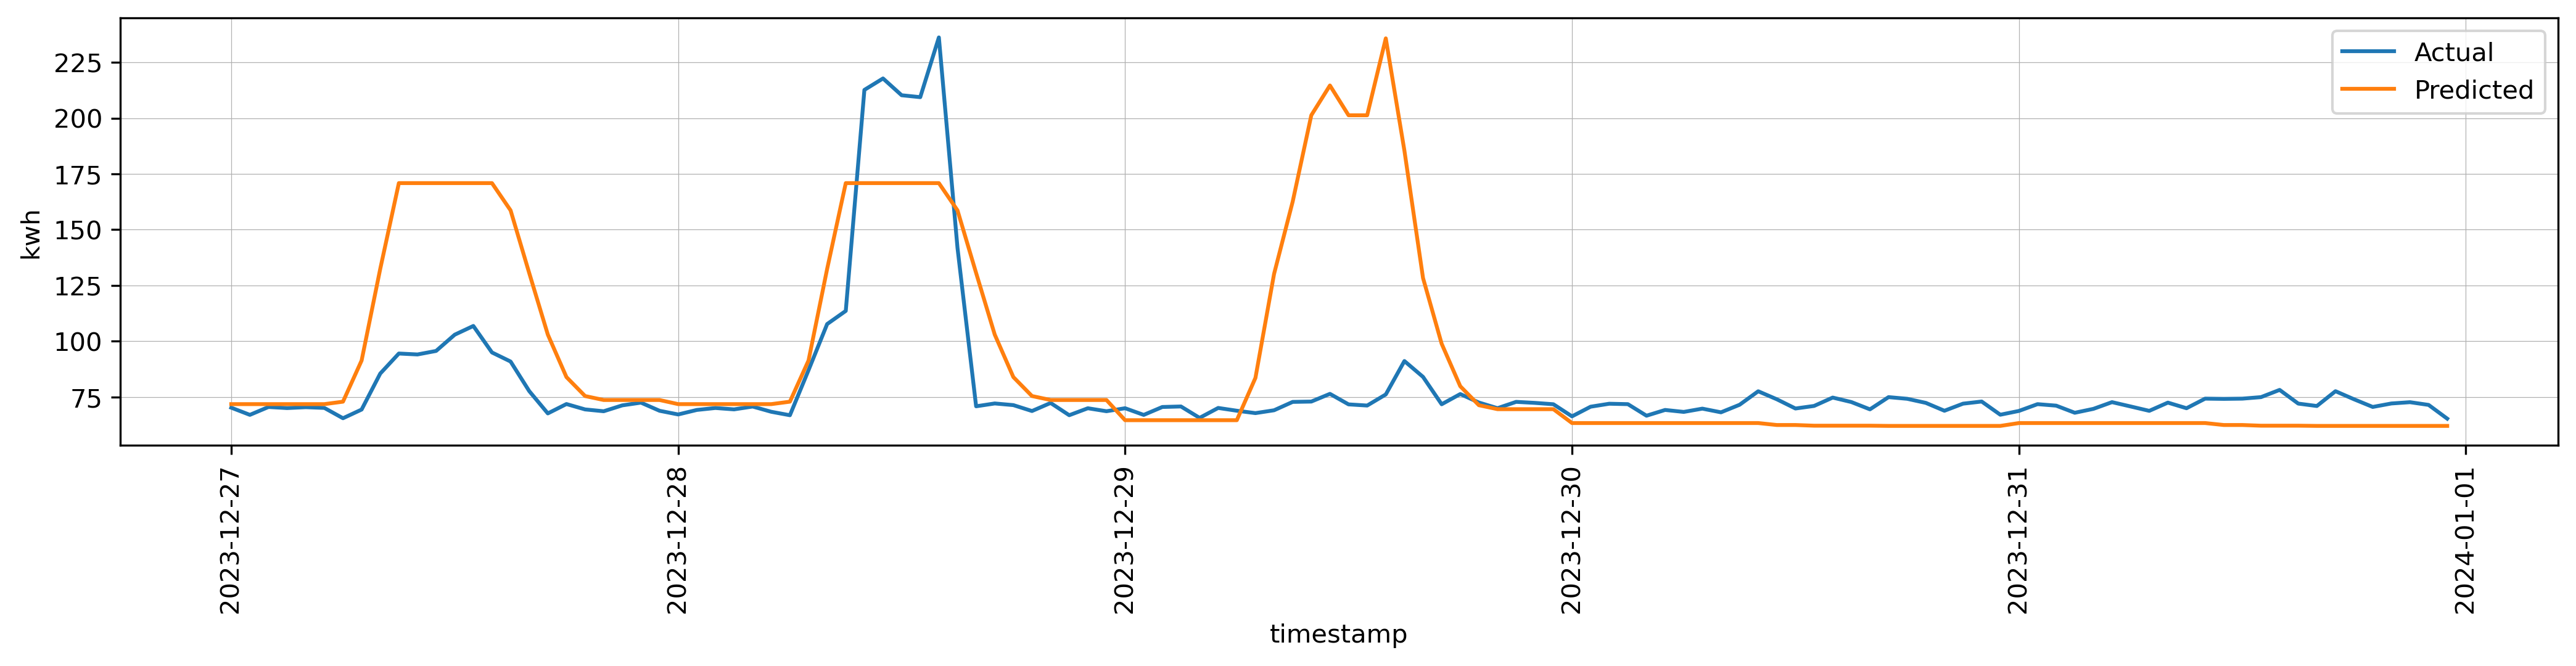

In [189]:
# Visualización
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh', label='Actual')
sns.lineplot(data=test_results, x='timestamp', y='predictions', label='Predicted')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()